In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
DRIVE_ROOT = "/content/drive/MyDrive/wm_global32"
OUTPUT_DIR = f"{DRIVE_ROOT}/output"
os.environ["DRIVE_ROOT"] = DRIVE_ROOT
os.environ["OUTPUT_DIR"] = OUTPUT_DIR
os.makedirs(OUTPUT_DIR, exist_ok=True)
print("OUTPUT_DIR:", OUTPUT_DIR)



Mounted at /content/drive
OUTPUT_DIR: /content/drive/MyDrive/wm_global32/output


In [ ]:
# GPU 확인
!nvidia-smi

# 프로젝트 폴더 생성 및 이동
%cd /content
!mkdir -p /content/wm_global32
%cd /content/wm_global32

# 라이브러리 설치
!pip -q install pillow tqdm torchvision



Mon Jan  5 06:04:40 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   32C    P0             52W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
%%bash
# 1. 디렉토리 생성
mkdir -p /content/coco_zips
mkdir -p /content/coco

# 2. 다운로드 (파일이 없을 때만)
cd /content/coco_zips
[ -f train2017.zip ] || wget -q http://images.cocodataset.org/zips/train2017.zip
[ -f val2017.zip ] || wget -q http://images.cocodataset.org/zips/val2017.zip
[ -f annotations_trainval2017.zip ] || wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# 3. 압축 해제 (폴더가 없을 때만)
# -n 옵션은 동일 파일이 있을 때 덮어쓰지 않음
unzip -nq /content/coco_zips/train2017.zip -d /content/coco
unzip -nq /content/coco_zips/val2017.zip -d /content/coco
unzip -nq /content/coco_zips/annotations_trainval2017.zip -d /content/coco

echo "COCO 데이터셋 준비 완료!"

COCO 데이터셋 준비 완료!


In [ ]:
%%writefile /content/wm_global32/models.py
import torch
import torch.nn as nn
from torchvision import models

# detector ViT 이 값으로 정규화된 데이터로 학습
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406])
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225])

# 128차원으로 비트 확장
class MsgEncoder(nn.Module):
    def __init__(self, nbits=32, msg_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nbits, msg_dim),
            nn.LeakyReLU(0.2, inplace=True), # 음수일때 0.2로 살림
            nn.Linear(msg_dim, msg_dim),
        )

    def forward(self, msg):
        return self.net(msg)

# (입력채널,출력채널,커널크기,s,p), 입력 224*224*3
class Embedder(nn.Module):
    def __init__(self, nbits=32, msg_dim=128):
        super().__init__()
        self.msg_encoder = MsgEncoder(nbits, msg_dim)
        self.conv = nn.Sequential(
            nn.Conv2d(3 + msg_dim, 128, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 3, 3, padding=1),
        )
    """
    [64, 3, 224, 224]
    msg_feat: [batch,128] -> [batch, 128 , 1, 1]
    msg_map: 1*1 msg 블록을 이미지 크기만큼 늘림
    """

    def forward(self, imgs, msgs, alpha=0.5):
        b, c, h, w = imgs.shape
        msg_feat = self.msg_encoder(msgs).unsqueeze(-1).unsqueeze(-1)
        msg_map = msg_feat.expand(-1, -1, h, w)

        x = torch.cat([imgs, msg_map], dim=1) # 결합
        delta = self.conv(x)  # 워터마크 생성

        # 기존: imgs 전체에 tanh → 전역 왜곡 발생
        # imgs_w = torch.tanh(imgs + alpha * delta)

        # 수정: delta만 제한하고 원본 이미지는 선형 유지
        imgs_w = imgs + alpha * torch.tanh(delta)
        imgs_w = imgs_w.clamp(-1, 1)

        return imgs_w, delta

"""
이미지 전체 보는 셀프어텐션 vit
"""
class Detector(nn.Module):
    def __init__(self, nbits=32, freeze_backbone=True):
        super().__init__()
        self.backbone = models.vit_b_16(
            weights=models.ViT_B_16_Weights.DEFAULT
        )

        if freeze_backbone: # 특징 추출층 잠금
            for p in self.backbone.parameters():
                p.requires_grad = False

        # 1000개 출력층 -> 32개 출력층으로 변경
        in_feats = self.backbone.heads.head.in_features
        self.backbone.heads.head = nn.Linear(in_feats, nbits)

        # 모델과 함께 GPU로 이동됨 + state_dict에 포함되어 모델 저장/로드시 정보 유실방지
        self.register_buffer("mean", IMAGENET_MEAN.view(1,3,1,1))
        self.register_buffer("std", IMAGENET_STD.view(1,3,1,1))

    def forward(self, imgs):
        imgs = (imgs * 0.5 + 0.5).clamp(0, 1)
        imgs = (imgs - self.mean) / self.std
        return self.backbone(imgs)


Overwriting /content/wm_global32/models.py


In [ ]:
%%writefile /content/wm_global32/train.py
import argparse, os, torch, random, io
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from models import Embedder, Detector
import math


def compute_psnr(x, y):
    # x, y: [-1, 1] range, shape (B,3,H,W)
    mse = torch.mean((x - y) ** 2)
    if mse == 0:
        return 99.0
    return 10 * math.log10(4.0 / mse.item())


# Dataset
# -----------------------------
class ImageDataset(Dataset):
    def __init__(self, root, img_size=224):
        exts = {".jpg", ".jpeg", ".png"}
        self.paths = sorted([p for p in Path(root).rglob("*") if p.suffix.lower() in exts])
        self.tf = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3),
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        return self.tf(Image.open(self.paths[idx]).convert("RGB"))

# Differentiable attacks
# -----------------------------
def apply_geom_attacks(x):
    b, c, h, w = x.shape

    if random.random() < 0.4:
        scale = random.uniform(0.6, 1.1)
        nh, nw = int(h * scale), int(w * scale)
        x = F.interpolate(x, size=(nh, nw), mode='bilinear', align_corners=False)
        x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=False)

    if random.random() < 0.3:
        crop_ratio = random.uniform(0.7, 0.95)
        ch, cw = int(h * crop_ratio), int(w * crop_ratio)
        x = TF.center_crop(x, (ch, cw))
        x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=False)

    return x

def apply_jpeg_attack(x, device):
    with torch.no_grad():
        out = x.clone()
        b = out.size(0)
        quality = random.randint(50, 95)
        for i in range(b):
            img = TF.to_pil_image((out[i] * 0.5 + 0.5).clamp(0,1))
            buf = io.BytesIO()
            img.save(buf, format="JPEG", quality=quality)
            buf.seek(0)
            out[i] = TF.to_tensor(Image.open(buf)).to(device)
            out[i] = (out[i] - 0.5) / 0.5
    return out

# Utils
# -----------------------------
def bit_accuracy(logits, targets):
    preds = (logits > 0).float()
    return (preds == targets).float().mean().item()

def _save_checkpoint(ckpt, path):
    tmp = path + ".tmp"
    torch.save(ckpt, tmp)
    os.replace(tmp, path)

# Train
# -----------------------------
def train(args):
    device = "cuda"
    os.makedirs(args.output_dir, exist_ok=True)

    loader = DataLoader(
        ImageDataset(args.train_dir, args.img_size),
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True
    )

    embedder = Embedder(args.nbits).to(device)
    detector = Detector(args.nbits, freeze_backbone=True).to(device)

    opt = torch.optim.Adam(
        list(embedder.parameters()) +
        list(filter(lambda p: p.requires_grad, detector.parameters())),
        lr=args.lr
    )

    scaler = torch.amp.GradScaler('cuda', enabled=args.amp)

    last_ckpt = os.path.join(args.output_dir, "last.pt")
    start_epoch = 0

    if os.path.exists(last_ckpt):
      ckpt = torch.load(last_ckpt, map_location=device)

      embedder.load_state_dict(ckpt['embedder'])
      detector.load_state_dict(ckpt['detector'])

      # Detector는 고정
      for p in detector.parameters():
          p.requires_grad = False

      # Optimizer / Scaler는 새로 생성
      opt = torch.optim.Adam(
          embedder.parameters(),
          lr=args.lr
      )
      scaler = torch.amp.GradScaler('cuda', enabled=args.amp)
      start_epoch = 0
      print(">>> Warm-start resume: weights loaded, optimizer & scaler reset")


    for epoch in range(start_epoch, args.epochs):
        embedder.train()
        detector.eval()

        pbar = tqdm(loader, desc=f"Epoch {epoch}")
        for imgs in pbar:
            imgs = imgs.to(device, non_blocking=True)
            msgs = torch.randint(0, 2, (imgs.size(0), args.nbits), device=device).float()
            alpha = random.uniform(args.alpha_min, args.alpha_max)


            with torch.amp.autocast('cuda', enabled=args.amp):
                imgs_w, _ = embedder(imgs, msgs, alpha)

                # Phase 1: 품질 판정 단계 → 공격 OFF
                attacked = imgs_w
                logits = detector(attacked)

                loss_bit = F.binary_cross_entropy_with_logits(logits, msgs)
                loss_img = F.mse_loss(imgs_w, imgs)
                loss = loss_bit + args.lambda_img * loss_img
            with torch.no_grad():
                psnr = compute_psnr(imgs_w, imgs)


            opt.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            pbar.set_postfix(loss=loss.item(), acc=bit_accuracy(logits, msgs), psnr=f"{psnr:.2f}dB")

        ckpt = {
            "epoch": epoch,
            "embedder": embedder.state_dict(),
            "detector": detector.state_dict(),
            "optimizer": opt.state_dict(),
            "scaler": scaler.state_dict(),
        }
        _save_checkpoint(ckpt, last_ckpt)

if __name__ == "__main__":
    p = argparse.ArgumentParser()
    p.add_argument("--train_dir", type=str, required=True)
    p.add_argument("--val_dir", type=str, required=True)
    p.add_argument("--output_dir", type=str, required=True)
    p.add_argument("--img_size", type=int, default=224)
    p.add_argument("--nbits", type=int, default=32)
    p.add_argument("--batch_size", type=int, default=64)
    p.add_argument("--epochs", type=int, default=200)
    p.add_argument("--lr", type=float, default=1e-4)
    p.add_argument("--lambda_img", type=float, default=1.0)
    p.add_argument("--amp", action="store_true")
    p.add_argument("--alpha_min", type=float, default=0.05)
    p.add_argument("--alpha_max", type=float, default=0.15)

    train(p.parse_args())


Overwriting /content/wm_global32/train.py


In [ ]:

!python /content/wm_global32/train.py \
    --train_dir /content/coco/train2017 \
    --val_dir /content/coco/val2017 \
    --output_dir "$OUTPUT_DIR" \
    --img_size 224 \
    --nbits 32 \
    --batch_size 64 \
    --epochs 10\
    --lambda_img 0.3 \
    --lr 1e-4 \
    --amp

Epoch 0: 100% 1849/1849 [04:29<00:00,  6.87it/s, acc=0.558, loss=0.68, psnr=25.62dB]
Epoch 1: 100% 1849/1849 [04:28<00:00,  6.89it/s, acc=0.65, loss=0.636, psnr=29.86dB]
Epoch 2: 100% 1849/1849 [04:28<00:00,  6.89it/s, acc=0.633, loss=0.621, psnr=29.25dB]
Epoch 3: 100% 1849/1849 [04:28<00:00,  6.88it/s, acc=0.621, loss=0.628, psnr=29.83dB]
Epoch 4: 100% 1849/1849 [04:28<00:00,  6.88it/s, acc=0.621, loss=0.61, psnr=28.87dB]
Epoch 5: 100% 1849/1849 [04:28<00:00,  6.88it/s, acc=0.633, loss=0.595, psnr=25.09dB]
Epoch 6: 100% 1849/1849 [04:28<00:00,  6.88it/s, acc=0.635, loss=0.599, psnr=25.76dB]
Epoch 7: 100% 1849/1849 [04:28<00:00,  6.89it/s, acc=0.623, loss=0.6, psnr=33.32dB]
Epoch 8: 100% 1849/1849 [04:28<00:00,  6.88it/s, acc=0.654, loss=0.559, psnr=25.55dB]
Epoch 9: 100% 1849/1849 [04:28<00:00,  6.88it/s, acc=0.631, loss=0.606, psnr=29.89dB]


phase 2

In [ ]:
!python train.py \
  --train_dir /content/coco/train2017 \
  --val_dir   /content/coco/val2017 \
  --output_dir "$OUTPUT_DIR" \
  --img_size 224 \
  --nbits 32 \
  --batch_size 64 \
  --epochs 30 \
  --lambda_img 0.5 \
  --lr 1e-4 \
  --alpha_min 0.08 \
  --alpha_max 0.18 \
  --amp


>>> Warm-start resume: weights loaded, optimizer & scaler reset
Epoch 0: 100% 1849/1849 [04:29<00:00,  6.87it/s, acc=0.652, loss=0.554, psnr=26.02dB]
Epoch 1: 100% 1849/1849 [04:28<00:00,  6.89it/s, acc=0.621, loss=0.568, psnr=27.22dB]
Epoch 2:  35% 648/1849 [01:34<02:53,  6.91it/s, acc=0.662, loss=0.555, psnr=24.44dB]^C


In [ ]:
import os
import torch
import shutil
from datetime import datetime

# 경로 설정
OUTPUT_DIR = os.environ.get("OUTPUT_DIR", "/content/drive/MyDrive/wm_global32/output")

last_ckpt = os.path.join(OUTPUT_DIR, "last.pt")
baseline_ckpt = os.path.join(OUTPUT_DIR, "baseline_v1.pt")

assert os.path.exists(last_ckpt), "❌ last.pt 파일이 존재하지 않습니다."

# 1) 임시 파일로 복사 (atomic)
tmp_ckpt = baseline_ckpt + ".tmp"
shutil.copy2(last_ckpt, tmp_ckpt)

# 2) 최종 이름으로 교체
os.replace(tmp_ckpt, baseline_ckpt)

print(f"✅ Baseline v1 저장 완료: {baseline_ckpt}")

# 3) 메타 정보 기록
meta_path = os.path.join(OUTPUT_DIR, "baseline_v1_meta.txt")
with open(meta_path, "w") as f:
    f.write(
        f"""Baseline v1
=================
Saved at: {datetime.now()}
Epoch: 100
Dataset: COCO train2017
Image size: 224
nbits: 32
lambda_img: 0.01
Training details
----------------
Embedder:
  - CNN-based residual embedding
  - Output constraint: tanh(img + alpha * delta)

Detector:
  - Backbone: ViT-B/16 (ImageNet pretrained)
  - Backbone frozen (head-only training)

Loss:
  - L_bit: Binary Cross Entropy (logits)
  - L_img: MSE
  - Total: L = L_bit + 0.01 * L_img

Alpha:
  - Random uniform in [0.4, 0.6]

Attacks:
  - Resize: scale ∈ [0.6, 1.1], p = 0.4
  - Center crop: ratio ∈ [0.7, 0.95], p = 0.3
  - JPEG compression: quality ∈ [50, 95], p = 0.5

Notes:
  - Stable plateau (bit acc ≈ 0.94~0.96 with attacks)
  - Selected as service-ready baseline
"""
    )

print(f"📝 Baseline 메타 정보 저장 완료: {meta_path}")


✅ Baseline v1 저장 완료: /content/drive/MyDrive/wm_global32/output/baseline_v1.pt
📝 Baseline 메타 정보 저장 완료: /content/drive/MyDrive/wm_global32/output/baseline_v1_meta.txt


In [ ]:
import torch
from models import Embedder, Detector

ckpt_path = "/content/drive/MyDrive/wm_global32/output/baseline_v1.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"

ckpt = torch.load(ckpt_path, map_location=device)

embedder = Embedder(nbits=32).to(device)
detector = Detector(nbits=32, freeze_backbone=True).to(device)

embedder.load_state_dict(ckpt["embedder"])
detector.load_state_dict(ckpt["detector"])

embedder.eval()
detector.eval()

print("✅ Model load OK")


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 238MB/s]


✅ Model load OK


In [ ]:
%%writefile /content/wm_global32/inference_test.py
import torch
from torchvision import transforms
from PIL import Image, ImageOps
import numpy as np
import os
import argparse

from models import Embedder, Detector
from train import apply_geom_attacks, apply_jpeg_attack


# =========================================================
# Utils
# =========================================================
def fix_orientation(img):
    return ImageOps.exif_transpose(img)

def date_to_32bits(date_str):
    val = int(date_str)
    bin_str = format(val, '032b')
    return torch.tensor([float(b) for b in bin_str])

def tensor_to_uint8_image(x):
    """
    x: (1,3,H,W) or (3,H,W), range [-1,1]
    return: PIL Image (uint8)
    """
    if x.ndim == 4:
        x = x[0]

    x = (x * 0.5 + 0.5).clamp(0, 1)      # [-1,1] → [0,1]
    x = x.permute(1, 2, 0).cpu().numpy() # HWC
    x = (x * 255).astype(np.uint8)

    return Image.fromarray(x)

def save_tensor(x, path):
    img = tensor_to_uint8_image(x)
    img.save(path)


# =========================================================
# Main Test
# =========================================================
def run_test(args):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    os.makedirs(args.out_dir, exist_ok=True)

    # -----------------------------------------------------
    # 1. Load models
    # -----------------------------------------------------
    print("\n[1] 모델 로드")
    embedder = Embedder(nbits=args.nbits).to(device)
    detector = Detector(nbits=args.nbits, freeze_backbone=True).to(device)

    ckpt_path = os.path.join(args.ckpt_dir, "baseline_v1.pt")
    ckpt = torch.load(ckpt_path, map_location=device)

    embedder.load_state_dict(ckpt["embedder"])
    detector.load_state_dict(ckpt["detector"])

    embedder.eval()
    detector.eval()

    print(f"  ✔ Loaded checkpoint: {ckpt_path}")

    # -----------------------------------------------------
    # 2. Image load & preprocess
    # -----------------------------------------------------
    print("\n[2] 이미지 로드 및 전처리")
    raw_img = Image.open(args.img_path).convert("RGB")
    fixed_img = fix_orientation(raw_img)

    tf = transforms.Compose([
        transforms.Resize((args.img_size, args.img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3),
    ])

    img = tf(fixed_img).unsqueeze(0).to(device)

    save_tensor(img, os.path.join(args.out_dir, "step0_original.png"))

    # -----------------------------------------------------
    # 3. Message
    # -----------------------------------------------------
    print("\n[3] 메시지 생성")
    msg = date_to_32bits(args.message).unsqueeze(0).to(device)
    print(f"  Message bits: {args.message} → 32-bit")

    # -----------------------------------------------------
    # 4. Attack OFF
    # -----------------------------------------------------
    print("\n[4] Attack OFF 테스트")
    with torch.no_grad():
        img_w, _ = embedder(img, msg, alpha=args.alpha)
        logits = detector(img_w)

    preds = (logits > 0).float()
    acc = (preds == msg).float().mean().item() * 100
    wrong = int((preds != msg).sum().item())

    save_tensor(img_w, os.path.join(args.out_dir, "step1_watermarked_off.png"))

    print(f"  ✔ Bit Acc (OFF): {acc:.2f}% | Wrong bits: {wrong}")

    # -----------------------------------------------------
    # 5. Attack ON
    # -----------------------------------------------------
    print("\n[5] Attack ON 테스트 (Resize + Crop + JPEG)")
    with torch.no_grad():
        attacked = apply_geom_attacks(img_w)
        attacked = apply_jpeg_attack(attacked, device)
        logits_a = detector(attacked)

    preds_a = (logits_a > 0).float()
    acc_a = (preds_a == msg).float().mean().item() * 100
    wrong_a = int((preds_a != msg).sum().item())

    save_tensor(attacked, os.path.join(args.out_dir, "step2_attacked.png"))

    print(f"  ✔ Bit Acc (ON): {acc_a:.2f}% | Wrong bits: {wrong_a}")

    # -----------------------------------------------------
    # 6. Diff map
    # -----------------------------------------------------
    print("\n[6] 시각적 차이 분석")
    diff = (img_w - img).abs()
    save_tensor(diff, os.path.join(args.out_dir, "step3_diff.png"))

    print("\n[테스트 완료]")
    print(f"  결과 이미지 저장 위치: {args.out_dir}")


# =========================================================
# Entry
# =========================================================
if __name__ == "__main__":
    default_ckpt_dir = os.environ.get(
        "OUTPUT_DIR",
        "/content/drive/MyDrive/wm_global32/output"
    )

    p = argparse.ArgumentParser()
    p.add_argument("--img_path", type=str, required=True)
    p.add_argument("--ckpt_dir", type=str, default=default_ckpt_dir)
    p.add_argument("--out_dir", type=str, default="./test_outputs")
    p.add_argument("--message", type=str, default="20260101")
    p.add_argument("--alpha", type=float, default=0.5)
    p.add_argument("--img_size", type=int, default=224)
    p.add_argument("--nbits", type=int, default=32)

    run_test(p.parse_args())


Overwriting /content/wm_global32/inference_test.py


In [ ]:
%cd /content/wm_global32
!python inference_test.py \
  --img_path /content/drive/MyDrive/WMimg/wm_004.png \
  --message 20260101 \
  --alpha 0.5 \
  --out_dir /content/wm_global32/test_wm004


/content/wm_global32

[1] 모델 로드
  ✔ Loaded checkpoint: /content/drive/MyDrive/wm_global32/output/baseline_v1.pt

[2] 이미지 로드 및 전처리

[3] 메시지 생성
  Message bits: 20260101 → 32-bit

[4] Attack OFF 테스트
  ✔ Bit Acc (OFF): 93.75% | Wrong bits: 2

[5] Attack ON 테스트 (Resize + Crop + JPEG)
  ✔ Bit Acc (ON): 96.88% | Wrong bits: 1

[6] 시각적 차이 분석

[테스트 완료]
  결과 이미지 저장 위치: /content/wm_global32/test_wm004


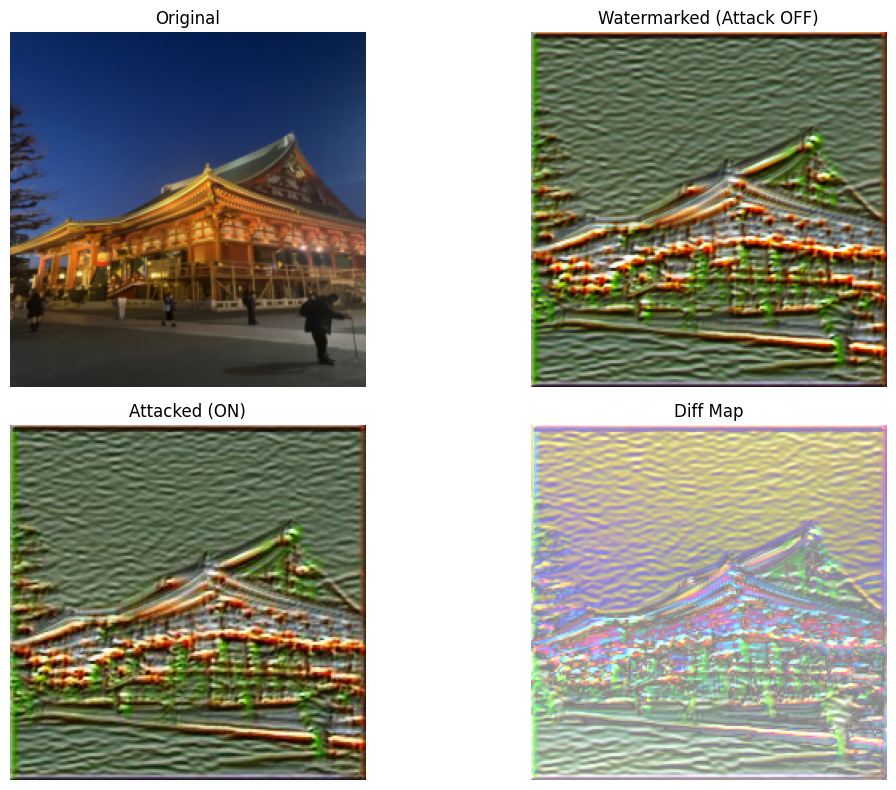

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# 결과 폴더 경로
out_dir = "/content/wm_global32/test_wm004"

files = [
    ("Original", "step0_original.png"),
    ("Watermarked (Attack OFF)", "step1_watermarked_off.png"),
    ("Attacked (ON)", "step2_attacked.png"),
    ("Diff Map", "step3_diff.png"),
]

plt.figure(figsize=(12, 8))

for i, (title, fname) in enumerate(files):
    path = os.path.join(out_dir, fname)
    img = Image.open(path)

    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

plt.tight_layout()
plt.show()


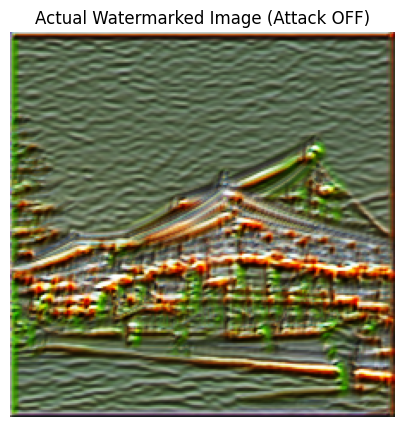

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/content/wm_global32/test_wm004/step1_watermarked_off.png")

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title("Actual Watermarked Image (Attack OFF)")
plt.axis("off")
plt.show()


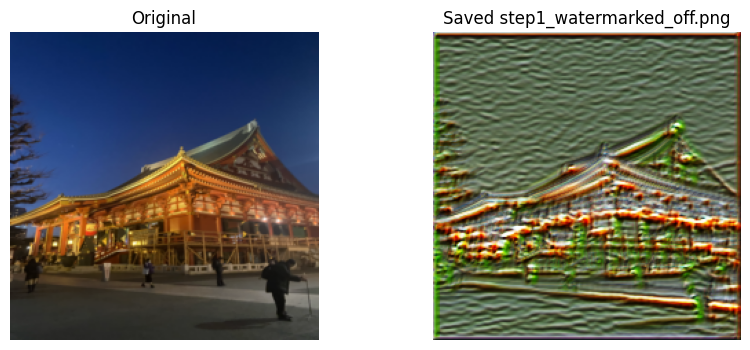

In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

# 원본
orig = Image.open("/content/wm_global32/test_wm004/step0_original.png")

# 문제의 워터마크 이미지
wm = Image.open("/content/wm_global32/test_wm004/step1_watermarked_off.png")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(orig)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(wm)
plt.title("Saved step1_watermarked_off.png")
plt.axis("off")
plt.show()


In [ ]:
import os, torch, numpy as np
from PIL import Image, ImageOps
from torchvision import transforms
from models import Embedder, Detector

device = "cuda" if torch.cuda.is_available() else "cpu"

CKPT_DIR = os.environ.get("OUTPUT_DIR", "/content/drive/MyDrive/wm_global32/output")
CKPT_PATH = os.path.join(CKPT_DIR, "baseline_v1.pt")
IMG_PATH  = "/content/drive/MyDrive/WMimg/wm_004.png"

nbits = 32
alpha = 0.5
message = "20260101"

def fix_orientation(img):
    return ImageOps.exif_transpose(img)

def date_to_32bits(date_str):
    val = int(date_str)
    bin_str = format(val, '032b')
    return torch.tensor([float(b) for b in bin_str])

def to_uint8(t):  # t: (1,3,H,W) in [-1,1]
    x = (t * 0.5 + 0.5).clamp(0,1)[0].permute(1,2,0).detach().cpu().numpy()
    return (x * 255).astype(np.uint8)

def psnr(a_u8, b_u8):
    a = a_u8.astype(np.float32) / 255.0
    b = b_u8.astype(np.float32) / 255.0
    mse = np.mean((a-b)**2)
    if mse == 0:
        return 99.0
    return 20*np.log10(1.0/np.sqrt(mse))

# load model
ckpt = torch.load(CKPT_PATH, map_location=device)
embedder = Embedder(nbits=nbits).to(device)
detector = Detector(nbits=nbits, freeze_backbone=True).to(device)
embedder.load_state_dict(ckpt["embedder"])
detector.load_state_dict(ckpt["detector"])
embedder.eval(); detector.eval()

# load image
raw = Image.open(IMG_PATH).convert("RGB")
img = fix_orientation(raw)

tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])
x = tf(img).unsqueeze(0).to(device)
msg = date_to_32bits(message).unsqueeze(0).to(device)

with torch.no_grad():
    xw, _ = embedder(x, msg, alpha=alpha)
    logits = detector(xw)

pred = (logits > 0).float()
acc = (pred == msg).float().mean().item() * 100
wrong = int((pred != msg).sum().item())

orig_u8 = to_uint8(x)
wm_u8   = to_uint8(xw)
diff_u8 = np.clip(np.abs(wm_u8.astype(np.int16)-orig_u8.astype(np.int16)), 0, 255).astype(np.uint8)

out_dir = "/content/wm_global32/quality_check_wm004"
os.makedirs(out_dir, exist_ok=True)
Image.fromarray(orig_u8).save(os.path.join(out_dir, "orig.png"))
Image.fromarray(wm_u8).save(os.path.join(out_dir, "wm.png"))
Image.fromarray(diff_u8).save(os.path.join(out_dir, "diff_u8.png"))

print(f"[wm_004] alpha={alpha}  BitAcc={acc:.2f}%  wrong={wrong}  PSNR={psnr(orig_u8, wm_u8):.2f} dB")
print("saved:", out_dir)


[wm_004] alpha=0.5  BitAcc=93.75%  wrong=2  PSNR=12.75 dB
saved: /content/wm_global32/quality_check_wm004


In [ ]:
mkdir -p /content/drive/MyDrive/datasets/COCO


In [ ]:
!cp -r /content/coco/train2017 /content/drive/MyDrive/datasets/COCO/
!cp -r /content/coco/val2017   /content/drive/MyDrive/datasets/COCO/
!cp -r /content/coco/annotations /content/drive/MyDrive/datasets/COCO/
